In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import sys
sys.setrecursionlimit(10000)

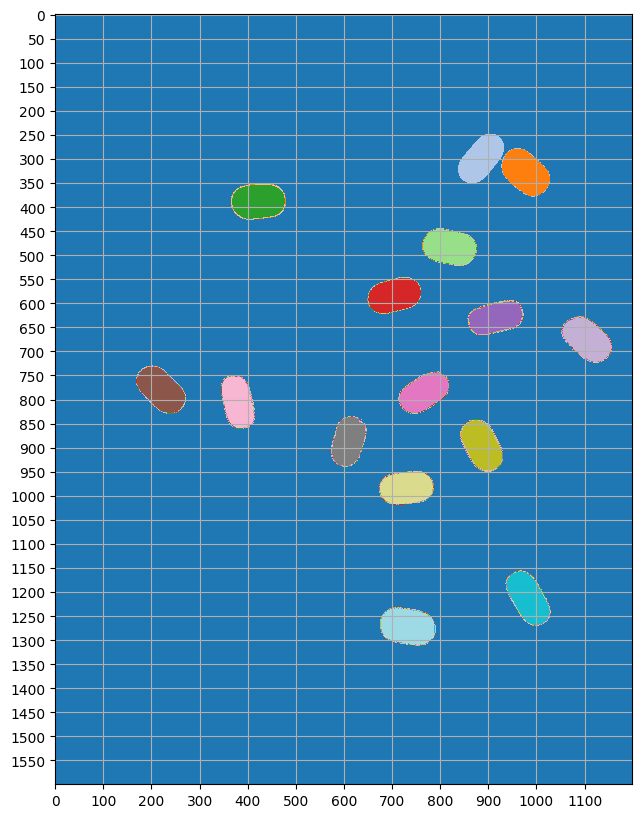

In [7]:
def find_neighbour(arr_np, i, j, size_row, size_col, label):
    if i < 0 or j < 0 or i >= size_row or j >= size_col or arr_np[i, j] != 1:
        return
    arr_np[i, j] = label
    explored_items.add((i, j))
    for k in range(-1, 2):
        for l in range(-1, 2):
            if k == 0 and l == 0:
                continue
            if (i + k, j + l) not in explored_items:
                find_neighbour(arr_np, i + k, j + l, size_row, size_col, label)

def connected_components(image):
    threshold = 130
    arr_np = np.where(image > threshold, 1, 0)
    size_row, size_col = arr_np.shape
    label = 2
    global explored_items
    explored_items = set()
    for i in range(size_row):
        for j in range(size_col):
            if arr_np[i, j] == 1 and (i, j) not in explored_items:
                find_neighbour(arr_np, i, j, size_row, size_col, label)
                label += 1
    return arr_np

def clean_image(image): # T o remove extra pixel which is not actually a object
    clean_label = []
    unique, counts = np.unique(image, return_counts=True)
    for i in range(len(unique)):
        if counts[i]<50:
            image[image==unique[i]] = 0
        else:
            clean_label.append(unique[i])
    clean_label.pop(0)
    for i in range(1, len(clean_label)+1):
        image[image==clean_label[i-1]] = i
    return image
        
    
image = cv2.imread('tablets.jpeg', cv2.IMREAD_GRAYSCALE)
labeled_image = clean_image(connected_components(image))
img_shape = labeled_image.shape

plt.figure(figsize = (10,10))
plt.imshow(labeled_image, cmap='tab20')
plt.grid()
plt.xticks(np.arange(0, img_shape[1], 100))
plt.yticks(np.arange(0, img_shape[0], 50))
plt.show()

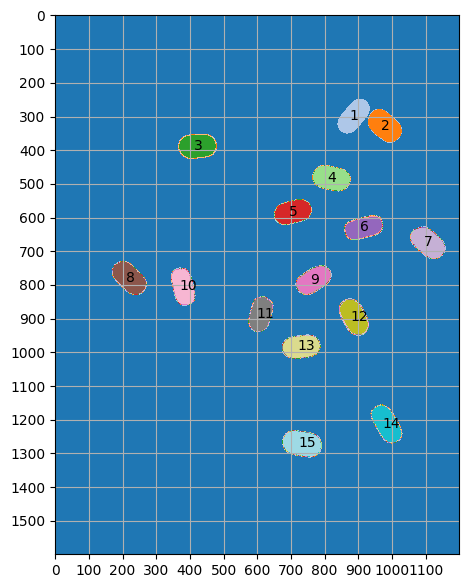

In [8]:
def generate_moments(image):
    li = ["m11", "m02", "m20", "m01", "m10", "m00", "mean_x", "mean_y", "mu20", "mu02", "mu11", "theta", "theta_degree", "start_x", "start_y"]
    M_table_dict = { each: {i: 0 for i in range(1, np.max(image)+1)} for each in li}
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            if labeled_image[i,j]:
                M_table_dict["m11"][image[i,j]] += (i * j)
                M_table_dict["m02"][image[i,j]] += (j**2)
                M_table_dict["m20"][image[i,j]] += (i**2)
                M_table_dict["m01"][image[i,j]] += j
                M_table_dict["m10"][image[i,j]] += i
                M_table_dict["m00"][image[i,j]] += 1
                if not M_table_dict["start_x"][image[i,j]]:
                    M_table_dict["start_x"][image[i,j]] = j
                if not M_table_dict["start_y"][image[i,j]]:
                    M_table_dict["start_y"][image[i,j]] = i

    plt.figure(figsize = (7,7))
    plt.imshow(image, cmap='tab20')
    
    for i, each in enumerate(M_table_dict['m11']):
        M_table_dict["mean_x"][each] = M_table_dict["m10"][each]/M_table_dict["m00"][each]
        M_table_dict["mean_y"][each] = M_table_dict["m01"][each]/M_table_dict["m00"][each]
        M_table_dict["mu20"][each] = M_table_dict["m20"][each]/M_table_dict["m00"][each] - M_table_dict["mean_x"][each]**2
        M_table_dict["mu02"][each] = M_table_dict["m02"][each]/M_table_dict["m00"][each] - M_table_dict["mean_y"][each]**2
        M_table_dict["mu11"][each] = M_table_dict["m11"][each]/M_table_dict["m00"][each] - M_table_dict["mean_x"][each]*M_table_dict["mean_y"][each]    
        M_table_dict["theta"][each] = 1/2 * np.arctan2( 2 * M_table_dict["mu11"][each], (M_table_dict["mu20"][each] - M_table_dict["mu02"][each]) )
        M_table_dict["theta_degree"][each] = np.degrees(M_table_dict["theta"][each])
        
        plt.text(M_table_dict["mean_y"][each] - 10, M_table_dict["mean_x"][each] + 10, str(i+1))
    
    plt.grid()
    plt.xticks(np.arange(0, img_shape[1], 100))
    plt.yticks(np.arange(0, img_shape[0], 100))
    plt.show()

    return M_table_dict

moments = generate_moments(labeled_image)
# for each in moments:
#     print(each, moments[each])
#     print()
    

In [9]:
dimensions = []
edge_locs = []
for i in range(1, np.max(labeled_image)+1):
    edge_points = [0 for i in range(4)]
    directions = [0, np.pi/2, np.pi, -np.pi/2] # left, bottom, right, top
    theta = moments['theta'][i]
    edge_pos = [0 for i in range(4)]
    k = 1
    while True:
        for l in range(4):
            if not edge_points[l]:
                val_x = int(moments['mean_x'][i] + k*np.cos(theta + directions[l]))
                val_y = int(moments['mean_y'][i] + k*np.sin(theta + directions[l]))
                if labeled_image[val_x, val_y] != i:
                    edge_points[l] = k - 1
                    edge_pos[l] = (int(moments['mean_x'][i] + k*np.cos(theta + directions[l])),
                                   int(moments['mean_y'][i] + k*np.sin(theta + directions[l])))
        if all(edge_points):
            break
        k+=1
    print(i, "- theta in degree:", math.floor(moments['theta_degree'][i]*100)/100,  "length:", edge_points[0] + edge_points[2], "  width:", edge_points[1] + edge_points[3])
    dimensions.append((edge_points[0] + edge_points[2], edge_points[1] + edge_points[3]))
    edge_locs.append(edge_pos)


dimensions = np.array(dimensions)

r1 = np.mean(dimensions[:,0]) 
print("Length Mean: ", r1) 

r2 = np.mean(dimensions[:,1]) 
print("Width Mean: ", r2) 
  
r3 = np.std(dimensions[:,0]) 
print("Length Std: ", r3) 

r4 = np.std(dimensions[:,1]) 
print("Width Std: ", r4) 

1 - theta in degree: -39.49 length: 118   width: 64
2 - theta in degree: 46.92 length: 111   width: 73
3 - theta in degree: -86.76 length: 113   width: 73
4 - theta in degree: 79.36 length: 112   width: 69
5 - theta in degree: -75.09 length: 112   width: 65
6 - theta in degree: -75.78 length: 115   width: 60
7 - theta in degree: 50.89 length: 112   width: 66
8 - theta in degree: 46.34 length: 115   width: 64
9 - theta in degree: -58.61 length: 110   width: 62
10 - theta in degree: 14.01 length: 108   width: 58
11 - theta in degree: -14.87 length: 105   width: 62
12 - theta in degree: 28.76 length: 113   width: 67
13 - theta in degree: -83.97 length: 112   width: 64
14 - theta in degree: 30.5 length: 120   width: 62
15 - theta in degree: 79.33 length: 115   width: 71
Length Mean:  112.73333333333333
Width Mean:  65.33333333333333
Length Std:  3.567756842735908
Width Std:  4.376706016578628


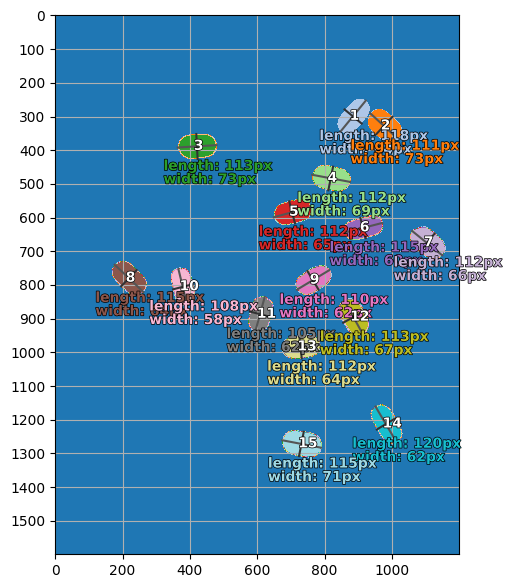

In [10]:
plt.figure(figsize = (7,7))
plt.imshow(labeled_image, cmap='tab20')
import matplotlib.patheffects as PathEffects
for i in range(1, np.max(labeled_image)+1):
    txt_head = plt.text(moments["mean_y"][i] - 10, moments["mean_x"][i] + 10, str(i), color = "white", weight='bold')
    txt_head.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='black')])
    txt1 = plt.text(moments["mean_y"][i] - 100, moments["mean_x"][i] + 70, "length: "+str(dimensions[i-1][0])+"px", color = plt.cm.tab20(int(i*20/np.max(labeled_image))), weight='bold')
    txt1.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='black')])
    txt2 = plt.text(moments["mean_y"][i] - 100, moments["mean_x"][i] + 110, "width: "+str(dimensions[i-1][1])+"px", color = plt.cm.tab20(int(i*20/np.max(labeled_image))), weight='bold')
    txt2.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='black')])
    #     if i == 1:
    #     print(edge_locs[i-1][0], edge_locs[i-1][2])
    plt.plot((edge_locs[i-1][0][1], edge_locs[i-1][2][1]), (edge_locs[i-1][0][0], edge_locs[i-1][2][0]), color="#555555")
    plt.plot((edge_locs[i-1][1][1], edge_locs[i-1][3][1]), (edge_locs[i-1][1][0], edge_locs[i-1][3][0]), color="#333333")

plt.grid()
plt.xticks(np.arange(0, img_shape[1], 200))
plt.yticks(np.arange(0, img_shape[0], 100))
plt.show()

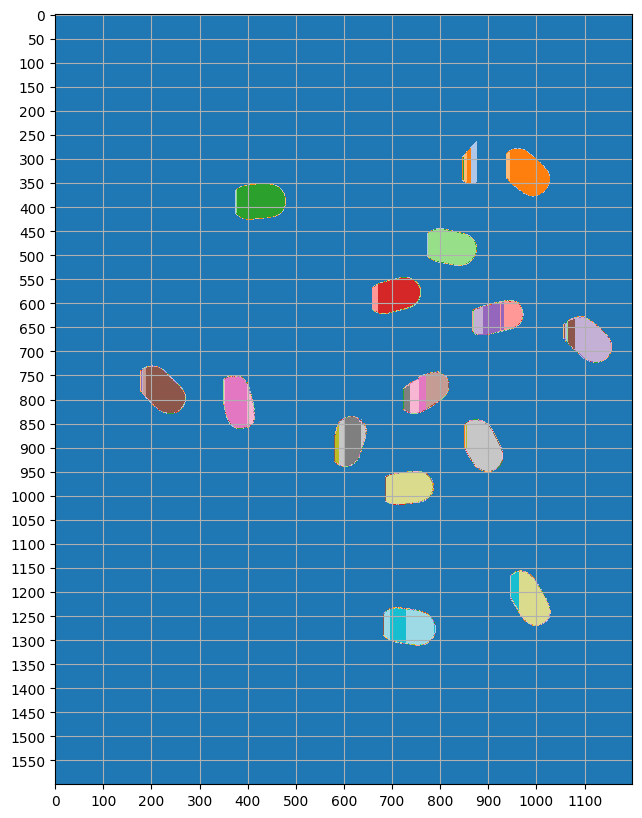

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def connected_components(image):
    threshold = 130
    arr_np = np.where(image > threshold, 1, 0)
    label = 2
    labels = np.zeros_like(arr_np)

    # First pass
    for i in range(1, arr_np.shape[0]):
        for j in range(1, arr_np.shape[1]):
            if arr_np[i, j] == 1:
                if arr_np[i - 1, j] != 0:
                    labels[i, j] = labels[i - 1, j]
                elif arr_np[i, j - 1] != 0:
                    labels[i, j] = labels[i, j - 1]
                else:
                    labels[i, j] = label
                    label += 1

    # Second pass
    for i in range(1, arr_np.shape[0]):
        for j in range(1, arr_np.shape[1]):
            if arr_np[i, j] == 1:
                if arr_np[i - 1, j] != 0 and arr_np[i - 1, j] != arr_np[i, j]:
                    labels[labels == labels[i - 1, j]] = labels[i, j]
                elif arr_np[i, j - 1] != 0 and arr_np[i, j - 1] != arr_np[i, j]:
                    labels[labels == labels[i, j - 1]] = labels[i, j]

    return labels

def clean_image(image):
    clean_label = []
    unique, counts = np.unique(image, return_counts=True)
    for i in range(len(unique)):
        if counts[i] < 50:
            image[image == unique[i]] = 0
        else:
            clean_label.append(unique[i])
    clean_label.pop(0)
    for i in range(1, len(clean_label) + 1):
        image[image == clean_label[i - 1]] = i
    return image
        
image = cv2.imread('tablets.jpeg', cv2.IMREAD_GRAYSCALE)
labeled_image = clean_image(connected_components(image))
img_shape = labeled_image.shape

plt.figure(figsize=(10, 10))
plt.imshow(labeled_image, cmap='tab20')
plt.grid()
plt.xticks(np.arange(0, img_shape[1], 100))
plt.yticks(np.arange(0, img_shape[0], 50))
plt.show()